# Neurog Internship: (Task 5 - Implementation Of Machine Learning & Deep Learning For The Prediction Of Technical Indicators. Also, Checked The Integrity Of The Data & Filled The Erroneous Data Using Linear Interpolation. Also Wrote A Python Script That Overwrites The Filtered CSV With The New Filtered CSV Using The Live Newly Fetched Data)

## All Libraries

In [1]:
# For Vizualization & Plotting
import matplotlib.pyplot as plt

# Scikit-Learn Modules For Machine Learning & Data Manipulation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Keras Modules For Deep Learning
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Library For Technical Analysis
from ta.momentum import RSIIndicator
from ta.trend import PSARIndicator
from ta.trend import ADXIndicator

# Other Necessary Libraries
import pandas as pd
import copy

## All Declarations

In [ ]:
# Define the relative path to the CSV file
csv_filename = "BTCUSDT_1_Minute_From_2020_Till_Now.csv"

# Settig Up The Directory From The Directory Hierarchy
# Get the notebook's current directory
notebook_dir = os.path.dirname(os.path.abspath(__file__))

# Go up one level to the parent directory
parent_dir = os.path.dirname(script_dir)

# Create the full path to the output CSV file in the 'ohlc' directory within 'data'
data_dir = os.path.join(parent_dir, "data")
ohlc_dir = os.path.join(data_dir, "ohlc")
full_csv_path = os.path.join(ohlc_dir, csv_filename)

## (Function To Convert DF To Any Timeframe) - Taken From The Previous Day

In [2]:
# Functions converts the dataframe into any given time frame.
def convert_1m_to_any_timeframe(df: pd.DataFrame, timeframe: str) -> pd.DataFrame:
    """
    Convert a DataFrame of 1-minute OHLC data to any given timeframe.

    Args:
    - df (pd.DataFrame): DataFrame containing 1-minute OHLC data. 
      The DataFrame should have a datetime index & columns ['Open', 'High', 'Low', 'Close', 'Volume'].
    - timeframe (str): The desired timeframe to resample the data to (e.g., '1H' for 1 hour, '1D' for 1 day).

    Returns:
    - pd.DataFrame: Resampled DataFrame with OHLC data in the specified timeframe. The index will be renamed to
      reflect the new timeframe.

    Example:
    ```
    resampled_df = convert_1m_to_any_timeframe(ohlc_df, '1H')
    ```
    """
    # Ensure the DataFrame index is of datetime type
    df.index = pd.to_datetime(df.index)
    
    # Try resampling the data to the desired timeframe
    try:
        df_resampled = df.resample(timeframe).agg({
            'Open': 'first',  # Take the first 'Open' value in the timeframe
            'High': 'max',    # Take the maximum 'High' value in the timeframe
            'Low': 'min',     # Take the minimum 'Low' value in the timeframe
            'Close': 'last',  # Take the last 'Close' value in the timeframe
            'Volume': 'mean'  # Take the mean 'Volume' value in the timeframe
        })
    except Exception as e:
        print(f"An error occurred while resampling! Error message: {e}")
        return pd.DataFrame()  # Return an empty DataFrame in case of error

    # Rename the index to reflect the new timeframe
    df_resampled.index.rename(f'Open time ({timeframe})', inplace = True)
    
    return df_resampled

## Utility Functions

In [3]:
# Optimized function to check conditions
def check_conditions_optimized(df):
    conditions = []

    # Check conditions using vectorized operations
    # They are significantly faster than just simply
    # looping over each row..
    conditions.append(df['Open'] > df['High'])
    conditions.append(df['Open'] < df['Low'])
    conditions.append(df['Close'] > df['High'])
    conditions.append(df['Close'] < df['Low'])
    conditions.append(df['Low'] > df['High'])
    conditions.append(df['High'] < df['Low'])

    # Concatenate all conditions and filter rows that satisfy any condition
    all_conditions = pd.concat(conditions, axis=1)
    indices = all_conditions.any(axis=1)

    # Print rows that meet conditions
    for idx, row in df[indices].iterrows():
        if row['Open'] > row['High']:
            print(f"Row {idx}: Open > High")
        if row['Open'] < row['Low']:
            print(f"Row {idx}: Open < Low")
        if row['Close'] > row['High']:
            print(f"Row {idx}: Close > High")
        if row['Close'] < row['Low']:
            print(f"Row {idx}: Close < Low")
        if row['Low'] > row['High']:
            print(f"Row {idx}: Low > High")
        if row['High'] < row['Low']:
            print(f"Row {idx}: High < Low")

# Function that saves the dataframe into a csv given the file name
def save_to_csv(df: pd.DataFrame, filename: str):
    """
    Save DataFrame to a CSV file.

    Args:
    - df (pd.DataFrame): DataFrame containing the data to be saved.
    - filename (str): Name of the CSV file to save.

    Returns:
    - None

    Raises:
    - ValueError: If the DataFrame (`df`) is empty or `filename` is empty.

    """
    if df.empty:
        raise ValueError("DataFrame is empty. Nothing to save.")
    
    if not filename:
        raise ValueError("Invalid filename provided.")
        
    # Construct the full path
    data_dir = os.path.join("..", "data")
    ohlc_dir = os.path.join(data_dir, "ohlc")
    full_path = os.path.join(ohlc_dir, filename)

    try:
        df.to_csv(full_path, index = True)
        print(f"Data saved to {full_path}")
    except Exception as e:
        print(f"Failed to save data to {full_path}. Error: {e}")

## RSI Indicator Function

In [4]:
def calculate_rsi(df: pd.DataFrame, window: int = 14) -> pd.DataFrame:
    """
    Calculate the Relative Strength Index (RSI) using the ta library.

    Args:
    - df (pd.DataFrame): DataFrame containing 'Close' price data.
    - window (int): The window size for calculating RSI, default is 14.

    Returns:
    - pd.DataFrame: DataFrame with the RSI values.
    """
    # Calculate RSI using ta library
    rsi_indicator = RSIIndicator(close=df['Close'], window=window, fillna=True)
    df['RSI'] = rsi_indicator.rsi()

    return df

def generate_signals(df: pd.DataFrame, rsi_lower: int = 20, rsi_upper: int = 80) -> pd.DataFrame:
    """
    Generate trading signals based on RSI values.

    Args:
    - df (pd.DataFrame): DataFrame containing 'RSI' values.
    - rsi_lower (int): RSI lower threshold for buy signals, default is 30.
    - rsi_upper (int): RSI upper threshold for sell signals, default is 70.

    Returns:
    - pd.DataFrame: DataFrame with trading signals.
    """
    df['Signal'] = 0  # Default no signal
    df.loc[df['RSI'] > rsi_upper, 'Signal'] = -1  # Sell signal
    df.loc[df['RSI'] < rsi_lower, 'Signal'] = 1   # Buy signal

    return df

## MACD Indicator Function

In [5]:
def calculate_macd(df: pd.DataFrame, short_window: int = 12, long_window: int = 26, signal_window: int = 9) -> pd.DataFrame:
    """
    Calculate the MACD (Moving Average Convergence Divergence) for a given DataFrame.

    Args:
    - df (pd.DataFrame): DataFrame containing 'Close' price data.
    - short_window (int): The window size for the short-term EMA, default is 12.
    - long_window (int): The window size for the long-term EMA, default is 26.
    - signal_window (int): The window size for the Signal line, default is 9.

    Returns:
    - pd.DataFrame: DataFrame with the MACD line and Signal line.
    """
    # Calculate the short-term and long-term EMAs
    df['EMA_12'] = df['Close'].ewm(span=short_window, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=long_window, adjust=False).mean()

    # Calculate the MACD line
    df['MACD'] = df['EMA_12'] - df['EMA_26']

    # Calculate the Signal line
    df['Signal_Line'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()

    return df

def generate_macd_signals(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generate trading signals based on MACD values.

    Args:
    - df (pd.DataFrame): DataFrame containing 'MACD' and 'Signal_Line' values.

    Returns:
    - pd.DataFrame: DataFrame with trading signals.
    """
    df['Signal'] = 0  # Default no signal
    df.loc[df['MACD'] > df['Signal_Line'], 'Signal'] = 1  # Buy signal
    df.loc[df['MACD'] < df['Signal_Line'], 'Signal'] = -1  # Sell signal

    return df

## ADX In Combination With Parabolic SAR Indicator Function

In [6]:
def calculate_adx(df: pd.DataFrame, window: int = 14) -> pd.DataFrame:
    """
    Calculate the Average Directional Index (ADX) and add it to the DataFrame.
    
    Args:
    - df (pd.DataFrame): DataFrame containing 'High', 'Low', and 'Close' columns.
    - window (int): Window size for the ADX calculation (default is 14).
    
    Returns:
    - df (pd.DataFrame): DataFrame with added 'ADX' column.
    """
    adx = ADXIndicator(df['High'], df['Low'], df['Close'], window=window)
    df['ADX'] = adx.adx()
    df['DI+'] = adx.adx_pos()
    df['DI-'] = adx.adx_neg()
    return df

def calculate_parabolic_sar(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the Parabolic SAR and add it to the DataFrame.
    
    Args:
    - df (pd.DataFrame): DataFrame containing 'High', 'Low', and 'Close' columns.
    
    Returns:
    - df (pd.DataFrame): DataFrame with added 'Parabolic_SAR' column.
    """
    psar = PSARIndicator(df['High'], df['Low'], df['Close'])
    df['Parabolic_SAR'] = psar.psar()
    return df

def generate_adx_parabolic_sar_signals(df: pd.DataFrame, adx_threshold: float = 25) -> pd.DataFrame:
    """
    Generate trading signals based on ADX and Parabolic SAR.

    Args:
    - df (pd.DataFrame): DataFrame containing 'ADX' and 'Parabolic_SAR' columns.
    - adx_threshold (float): Threshold for ADX to consider a strong trend (default is 25).

    Returns:
    - df (pd.DataFrame): DataFrame with added 'Signal' column (1 for buy, -1 for sell, 0 for hold).
    """
    df['Signal'] = 0  # Default to hold
    df.loc[(df['ADX'] > adx_threshold) & (df['Close'] > df['Parabolic_SAR']), 'Signal'] = 1  # Buy signal
    df.loc[(df['ADX'] > adx_threshold) & (df['Close'] < df['Parabolic_SAR']), 'Signal'] = -1  # Sell signal
    return df

## Main

### Reading The Previously Saved Data For BTCUSDT

In [228]:
BTCUSDT_Filtered_data_1M = pd.read_csv(full_csv_path)
BTCUSDT_Filtered_data_1M.set_index('Open time (1M)', inplace = True)

# Convert the index to datetime format
BTCUSDT_Filtered_data_1M.index = pd.to_datetime(BTCUSDT_Filtered_data_1M.index)

In [229]:
BTCUSDT_Filtered_data_1M

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
Open time (1M),,,,,,,,,
2020-01-01 00:00:00,7169.71,7169.71,7165.44,7167.83,3509.860,2.515594e+07,139,1025.400,7.348382e+06
2020-01-01 00:01:00,7167.83,7168.28,7158.66,7159.95,3821.170,2.737640e+07,155,1571.990,1.126101e+07
2020-01-01 00:02:00,7161.03,7165.40,7161.03,7162.46,3041.710,2.178758e+07,122,1439.790,1.031332e+07
2020-01-01 00:03:00,7161.74,7164.27,7160.30,7161.03,3682.650,2.637680e+07,147,1557.630,1.115700e+07
2020-01-01 00:04:00,7161.03,7164.25,7160.15,7160.15,2936.690,2.103310e+07,113,1407.430,1.007968e+07
...,...,...,...,...,...,...,...,...,...
2024-07-01 14:37:00,62901.50,62971.60,62666.40,62836.60,1.560,9.795988e+04,52,0.345,2.170379e+04
2024-07-01 14:38:00,62836.60,62888.00,62666.40,62836.60,7.676,4.818378e+05,78,3.687,2.318452e+05
2024-07-01 14:39:00,62836.60,62901.50,62666.40,62901.50,2.135,1.339093e+05,77,0.547,3.438058e+04


In [218]:
# I dont know why, but needed to shift time by 5 hours..
shift_amount = pd.Timedelta('5H')

# Shift the index
BTCUSDT_Filtered_data_1M.index = BTCUSDT_Filtered_data_1M.index.map(lambda x: x - shift_amount)

BTCUSDT_Filtered_data_1M

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
Open time (1M),,,,,,,,,
2019-12-31 19:00:00,7169.71,7169.71,7165.44,7167.83,3509.860,2.515594e+07,139,1025.400,7.348382e+06
2019-12-31 19:01:00,7167.83,7168.28,7158.66,7159.95,3821.170,2.737640e+07,155,1571.990,1.126101e+07
2019-12-31 19:02:00,7161.03,7165.40,7161.03,7162.46,3041.710,2.178758e+07,122,1439.790,1.031332e+07
2019-12-31 19:03:00,7161.74,7164.27,7160.30,7161.03,3682.650,2.637680e+07,147,1557.630,1.115700e+07
2019-12-31 19:04:00,7161.03,7164.25,7160.15,7160.15,2936.690,2.103310e+07,113,1407.430,1.007968e+07
...,...,...,...,...,...,...,...,...,...
2024-07-01 09:37:00,62901.50,62971.60,62666.40,62836.60,1.560,9.795988e+04,52,0.345,2.170379e+04
2024-07-01 09:38:00,62836.60,62888.00,62666.40,62836.60,7.676,4.818378e+05,78,3.687,2.318452e+05
2024-07-01 09:39:00,62836.60,62901.50,62666.40,62901.50,2.135,1.339093e+05,77,0.547,3.438058e+04


### Display Graph For Close Price (1 Minute Interval)

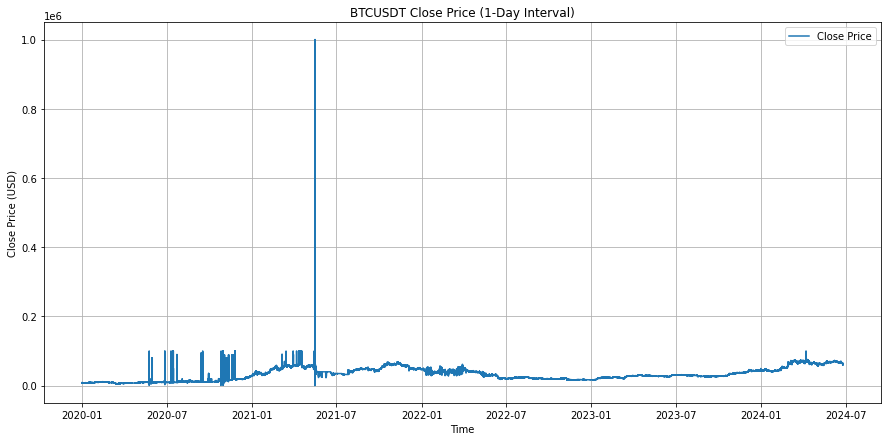

In [11]:
# Plot the 'Close' price over time
plt.figure(figsize=(15, 7))
plt.plot(BTCUSDT_Filtered_data_1M['Close'], label='Close Price')
plt.title('BTCUSDT Close Price (1-Day Interval)')
plt.xlabel('Time')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

## Now, Enough Plotting! On The Task!

## Generate Historical Data With Signals

### Changing Timeframe To 15 Minute Intervals

In [12]:
BTCUSDT_Filtered_data_15M = convert_1m_to_any_timeframe(copy.deepcopy(BTCUSDT_Filtered_data_1M), '15T')
BTCUSDT_Filtered_data_15M

,Open,High,Low,Close,Volume
Open time (15T),,,,,
2019-12-31 19:00:00,7169.71,7169.71,7158.06,7160.58,3175.798000
2019-12-31 19:15:00,7160.58,7181.91,7156.65,7175.42,3502.250667
2019-12-31 19:30:00,7175.42,7178.00,7167.70,7172.51,3551.520000
2019-12-31 19:45:00,7171.80,7183.07,7166.33,7174.14,2573.803333
2019-12-31 20:00:00,7173.42,7180.14,7164.51,7167.89,3410.840400
...,...,...,...,...,...
2024-06-25 06:00:00,62666.40,63992.00,61804.00,63960.00,1.978400
2024-06-25 06:15:00,63350.10,63981.60,61904.00,62800.00,1.693267
2024-06-25 06:30:00,62999.70,63991.00,61981.60,63991.00,1.747867


### Calculatng RSI and Generating Signals Using That

In [13]:
# Calculate RSI for the 1-Hour data
BTCUSDT_Filtered_data_15M_with_rsi = calculate_rsi(copy.deepcopy(BTCUSDT_Filtered_data_15M))

# Generate trading signals based on RSI
BTCUSDT_Filtered_data_15M_with_rsi = generate_signals(BTCUSDT_Filtered_data_15M_with_rsi)

# Print the data with RSI and signals
BTCUSDT_Filtered_data_15M_with_rsi

,Open,High,Low,Close,Volume,RSI,Signal
Open time (15T),,,,,,,
2019-12-31 19:00:00,7169.71,7169.71,7158.06,7160.58,3175.798000,100.000000,-1
2019-12-31 19:15:00,7160.58,7181.91,7156.65,7175.42,3502.250667,100.000000,-1
2019-12-31 19:30:00,7175.42,7178.00,7167.70,7172.51,3551.520000,82.564410,-1
2019-12-31 19:45:00,7171.80,7183.07,7166.33,7174.14,2573.803333,84.223696,-1
2019-12-31 20:00:00,7173.42,7180.14,7164.51,7167.89,3410.840400,60.463306,0
...,...,...,...,...,...,...,...
2024-06-25 06:00:00,62666.40,63992.00,61804.00,63960.00,1.978400,67.124809,0
2024-06-25 06:15:00,63350.10,63981.60,61904.00,62800.00,1.693267,57.261509,0
2024-06-25 06:30:00,62999.70,63991.00,61981.60,63991.00,1.747867,63.234811,0


### Calculatng MACD and Generating Signals Using That

In [14]:
# Calculate MACD for the 1-Day data
BTCUSDT_Filtered_data_15M_with_macd = calculate_macd(copy.deepcopy(BTCUSDT_Filtered_data_15M))

# Generate trading signals based on MACD
BTCUSDT_Filtered_data_15M_with_macd = generate_macd_signals(BTCUSDT_Filtered_data_15M_with_macd)

# Print the data with MACD, Signal line, and signals
BTCUSDT_Filtered_data_15M_with_macd

,Open,High,Low,Close,Volume,EMA_12,EMA_26,MACD,Signal_Line,Signal
Open time (15T),,,,,,,,,,
2019-12-31 19:00:00,7169.71,7169.71,7158.06,7160.58,3175.798000,7160.580000,7160.580000,0.000000,0.000000,0
2019-12-31 19:15:00,7160.58,7181.91,7156.65,7175.42,3502.250667,7162.863077,7161.679259,1.183818,0.236764,1
2019-12-31 19:30:00,7175.42,7178.00,7167.70,7172.51,3551.520000,7164.347219,7162.481536,1.865683,0.562547,1
2019-12-31 19:45:00,7171.80,7183.07,7166.33,7174.14,2573.803333,7165.853801,7163.345126,2.508674,0.951773,1
2019-12-31 20:00:00,7173.42,7180.14,7164.51,7167.89,3410.840400,7166.167062,7163.681784,2.485279,1.258474,1
...,...,...,...,...,...,...,...,...,...,...
2024-06-25 06:00:00,62666.40,63992.00,61804.00,63960.00,1.978400,62223.697042,61676.140617,547.556425,337.376892,1
2024-06-25 06:15:00,63350.10,63981.60,61904.00,62800.00,1.693267,62312.359035,61759.389460,552.969575,380.495429,1
2024-06-25 06:30:00,62999.70,63991.00,61981.60,63991.00,1.747867,62570.611492,61924.693944,645.917547,433.579853,1


### Calculatng ADX With PSAR and Generating Signals Using That

In [99]:
# Calculate ADX and Parabolic SAR
BTCUSDT_Filtered_data_15M_with_adx = calculate_adx(copy.deepcopy(BTCUSDT_Filtered_data_15M))
BTCUSDT_Filtered_data_15M_with_adx_and_sar = calculate_parabolic_sar(BTCUSDT_Filtered_data_15M_with_adx)

# Generate trading signals
BTCUSDT_Filtered_data_1D_with_adx_and_sar = generate_adx_parabolic_sar_signals(BTCUSDT_Filtered_data_15M_with_adx_and_sar)

# Print the data with adx and sar
BTCUSDT_Filtered_data_15M_with_adx_and_sar

,Open,High,Low,Close,Volume,ADX,DI+,DI-,Parabolic_SAR,Signal
Open time (15T),,,,,,,,,,
2019-12-31 19:00:00,7169.71,7169.71,7158.06,7160.58,3175.798000,0.0,0.0,0.0,7160.580000,0
2019-12-31 19:15:00,7160.58,7181.91,7156.65,7175.42,3502.250667,0.0,0.0,0.0,7175.420000,0
2019-12-31 19:30:00,7175.42,7178.00,7167.70,7172.51,3551.520000,0.0,0.0,0.0,7169.710000,0
2019-12-31 19:45:00,7171.80,7183.07,7166.33,7174.14,2573.803333,0.0,0.0,0.0,7167.700000,0
2019-12-31 20:00:00,7173.42,7180.14,7164.51,7167.89,3410.840400,0.0,0.0,0.0,7183.070000,0
...,...,...,...,...,...,...,...,...,...,...
2024-06-25 06:00:00,62666.40,63992.00,61804.00,63960.00,1.978400,NaN,NaN,NaN,60742.164800,0
2024-06-25 06:15:00,63350.10,63981.60,61904.00,62800.00,1.693267,NaN,NaN,NaN,60807.241504,0
2024-06-25 06:30:00,62999.70,63991.00,61981.60,63991.00,1.747867,NaN,NaN,NaN,60871.016674,0


### Filling NaN Values On All Generated Historical Data & Preparing Them For Training & Testing

In [49]:
BTCUSDT_Filtered_data_15M_with_rsi = BTCUSDT_Filtered_data_15M_with_rsi.interpolate()
BTCUSDT_Filtered_data_15M_with_rsi

,Open,High,Low,Close,Volume,RSI,Signal
Open time (15T),,,,,,,
2019-12-31 19:00:00,7169.71,7169.71,7158.06,7160.58,3175.798000,100.000000,-1
2019-12-31 19:15:00,7160.58,7181.91,7156.65,7175.42,3502.250667,100.000000,-1
2019-12-31 19:30:00,7175.42,7178.00,7167.70,7172.51,3551.520000,82.564410,-1
2019-12-31 19:45:00,7171.80,7183.07,7166.33,7174.14,2573.803333,84.223696,-1
2019-12-31 20:00:00,7173.42,7180.14,7164.51,7167.89,3410.840400,60.463306,0
...,...,...,...,...,...,...,...
2024-06-25 06:00:00,62666.40,63992.00,61804.00,63960.00,1.978400,67.124809,0
2024-06-25 06:15:00,63350.10,63981.60,61904.00,62800.00,1.693267,57.261509,0
2024-06-25 06:30:00,62999.70,63991.00,61981.60,63991.00,1.747867,63.234811,0


In [ ]:
BTCUSDT_Filtered_data_15M_with_macd = BTCUSDT_Filtered_data_15M_with_macd.interpolate()
BTCUSDT_Filtered_data_15M_with_macd

In [ ]:
BTCUSDT_Filtered_data_15M_with_adx_and_sar_clean = BTCUSDT_Filtered_data_15M_with_adx_and_sar.iloc[:, :-5]
BTCUSDT_Filtered_data_15M_with_adx_and_sar_clean['Parabolic_SAR'] = BTCUSDT_Filtered_data_15M_with_adx_and_sar['Parabolic_SAR']
BTCUSDT_Filtered_data_15M_with_adx_and_sar_clean['Signal'] = BTCUSDT_Filtered_data_15M_with_adx_and_sar['Signal']
BTCUSDT_Filtered_data_15M_with_adx_and_sar_clean = BTCUSDT_Filtered_data_15M_with_adx_and_sar_clean.interpolate()
BTCUSDT_Filtered_data_15M_with_adx_and_sar_clean

## Applying Models On All Prepared Data

## For Data Generated With RSI

### Splitting Data Into Train & Test Splits

In [50]:
# Data preprocessing
X = BTCUSDT_Filtered_data_15M_with_rsi[['Open', 'High', 'Low', 'Close', 'Volume', 'RSI']]
y = BTCUSDT_Filtered_data_15M_with_rsi['Signal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Applying Random Forest

In [51]:
# Machine Learning Model - Random Forest
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       185
           0       1.00      1.00      1.00     31155
           1       1.00      1.00      1.00       101

    accuracy                           1.00     31441
   macro avg       1.00      1.00      1.00     31441
weighted avg       1.00      1.00      1.00     31441



### Applying LSTM

In [52]:
# Deep Learning Model - LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32)
y_pred_dl = model.predict(X_test)
y_pred_dl = y_pred_dl.astype('int64')
print(classification_report(y_test, y_pred_dl))

Epoch 1/10
3930/3930 [==============================] - 39s 9ms/step - loss: -0.1914 - accuracy: 0.9920
Epoch 2/10
3930/3930 [==============================] - 34s 9ms/step - loss: -0.5676 - accuracy: 0.9920
Epoch 3/10
3930/3930 [==============================] - 32s 8ms/step - loss: -0.9453 - accuracy: 0.9920
Epoch 4/10
3930/3930 [==============================] - 35s 9ms/step - loss: -1.3211 - accuracy: 0.9920
Epoch 5/10
3930/3930 [==============================] - 32s 8ms/step - loss: -1.6889 - accuracy: 0.9920
Epoch 6/10
3930/3930 [==============================] - 32s 8ms/step - loss: -2.0628 - accuracy: 0.9920
Epoch 7/10
3930/3930 [==============================] - 32s 8ms/step - loss: -2.4407 - accuracy: 0.9920
Epoch 8/10
3930/3930 [==============================] - 31s 8ms/step - loss: -2.8219 - accuracy: 0.9920
Epoch 9/10
3930/3930 [==============================] - 41s 10ms/step - loss: -3.1938 - accuracy: 0.9920
Epoch 10/10
983/983 [==============================] - 5s 4ms/s

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

## For Data Generated With MACD

### Splitting Data Into Train & Test Splits

In [115]:
# Data preprocessing
X = BTCUSDT_Filtered_data_15M_with_macd.iloc[:, :-1]
y = BTCUSDT_Filtered_data_15M_with_macd['Signal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X

,Open,High,Low,Close,Volume,EMA_12,EMA_26,MACD,Signal_Line
Open time (15T),,,,,,,,,
2019-12-31 19:00:00,7169.71,7169.71,7158.06,7160.58,3175.798000,7160.580000,7160.580000,0.000000,0.000000
2019-12-31 19:15:00,7160.58,7181.91,7156.65,7175.42,3502.250667,7162.863077,7161.679259,1.183818,0.236764
2019-12-31 19:30:00,7175.42,7178.00,7167.70,7172.51,3551.520000,7164.347219,7162.481536,1.865683,0.562547
2019-12-31 19:45:00,7171.80,7183.07,7166.33,7174.14,2573.803333,7165.853801,7163.345126,2.508674,0.951773
2019-12-31 20:00:00,7173.42,7180.14,7164.51,7167.89,3410.840400,7166.167062,7163.681784,2.485279,1.258474
...,...,...,...,...,...,...,...,...,...
2024-06-25 06:00:00,62666.40,63992.00,61804.00,63960.00,1.978400,62223.697042,61676.140617,547.556425,337.376892
2024-06-25 06:15:00,63350.10,63981.60,61904.00,62800.00,1.693267,62312.359035,61759.389460,552.969575,380.495429
2024-06-25 06:30:00,62999.70,63991.00,61981.60,63991.00,1.747867,62570.611492,61924.693944,645.917547,433.579853


### Applying Random Forest

In [117]:
# Machine Learning Model - Random Forest
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.98      0.98      0.98     15849
           0       0.00      0.00      0.00         1
           1       0.98      0.98      0.98     15591

    accuracy                           0.98     31441
   macro avg       0.65      0.65      0.65     31441
weighted avg       0.98      0.98      0.98     31441



C:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Applying LSTM

In [ ]:
# Deep Learning Model - LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32)
y_pred_dl = model.predict(X_test)
y_pred_dl = y_pred_dl.astype('int64')
print(classification_report(y_test, y_pred_dl))

## For Data Generated With ADX with PSAR

### Splitting Data Into Train & Test Splits

In [121]:
# Data preprocessing
X = BTCUSDT_Filtered_data_15M_with_adx_and_sar_clean.iloc[:, :-1]
y = BTCUSDT_Filtered_data_15M_with_adx_and_sar_clean['Signal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Applying Random Forest

In [123]:
# Machine Learning Model - Random Forest
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.78      0.61      0.69       398
           0       0.99      1.00      0.99     30668
           1       0.77      0.59      0.67       375

    accuracy                           0.99     31441
   macro avg       0.85      0.73      0.78     31441
weighted avg       0.98      0.99      0.99     31441



### Applying LSTM

In [ ]:
# Deep Learning Model - LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32)
y_pred_dl = model.predict(X_test)
y_pred_dl = y_pred_dl.astype('int64')
print(classification_report(y_test, y_pred_dl))

## Making Custom Trading Signal Generator Using LSTM & Custom Magnitude Calculator
### - Still In The Making

In [ ]:
def gain_calculator(fiat_amount,price_at_buy,price_at_sell):
    crypto_amount = (fiat_amount- (fiat_amount*0.25/100))/price_at_buy
    gain_from_sell = (price_at_sell * crypto_amount) - (price_at_sell * crypto_amount * 0.25/100)
    return gain_from_sell - fiat_amount

In [ ]:
def required_magnitude(current_price,fiat_amount):
    x = 0 
    while True:
        gain = gain_calculator(fiat_amount,current_price,current_price+x)
        if gain>0:
            break
        else:
            x += 0.01
    return x

In [ ]:
#predict future price using trained LSTM
pred_price = model.predict(historical_price)
#get current price
current_price = get_current_price()
#calcualet required magnitude of increase in price
mag = required_magnitude(current_price,fiat_amount)
#determine action
if pred_pricec - urrent_price >= mag:
    #buy
elif pred_price < current_price:
    #sell
else:
    #do nothing

## Checking The iIntegritiy of The Data

### Displaying The 1 Minute Interval Data

In [230]:
BTCUSDT_Filtered_data_1M

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
Open time (1M),,,,,,,,,
2020-01-01 00:00:00,7169.71,7169.71,7165.44,7167.83,3509.860,2.515594e+07,139,1025.400,7.348382e+06
2020-01-01 00:01:00,7167.83,7168.28,7158.66,7159.95,3821.170,2.737640e+07,155,1571.990,1.126101e+07
2020-01-01 00:02:00,7161.03,7165.40,7161.03,7162.46,3041.710,2.178758e+07,122,1439.790,1.031332e+07
2020-01-01 00:03:00,7161.74,7164.27,7160.30,7161.03,3682.650,2.637680e+07,147,1557.630,1.115700e+07
2020-01-01 00:04:00,7161.03,7164.25,7160.15,7160.15,2936.690,2.103310e+07,113,1407.430,1.007968e+07
...,...,...,...,...,...,...,...,...,...
2024-07-01 14:37:00,62901.50,62971.60,62666.40,62836.60,1.560,9.795988e+04,52,0.345,2.170379e+04
2024-07-01 14:38:00,62836.60,62888.00,62666.40,62836.60,7.676,4.818378e+05,78,3.687,2.318452e+05
2024-07-01 14:39:00,62836.60,62901.50,62666.40,62901.50,2.135,1.339093e+05,77,0.547,3.438058e+04


### Checking The Statistical Information Of The Data (For All Columns)

In [231]:
BTCUSDT_Filtered_data_1M.describe()

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
count,2.366682e+06,2.366682e+06,2.366682e+06,2.366682e+06,2.366682e+06,2.366682e+06,2.366682e+06,2.366682e+06,2.366682e+06
mean,3.256391e+04,3.274677e+04,3.246421e+04,3.259224e+04,1.594359e+03,3.079653e+07,1.005688e+02,7.482405e+02,1.515236e+07
std,1.808356e+04,1.869004e+04,1.801112e+04,1.832569e+04,4.458456e+04,3.644209e+08,2.441791e+03,1.657516e+04,1.343453e+08
min,5.000000e+02,6.000000e+02,1.000000e-02,1.500000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.912128e+04,1.917950e+04,1.908736e+04,1.912499e+04,4.462300e+01,1.183606e+06,2.000000e+01,1.775300e+01,4.761479e+05
50%,2.947010e+04,2.959000e+04,2.940250e+04,2.947840e+04,1.111060e+02,3.063189e+06,4.400000e+01,5.270300e+01,1.445771e+06
75%,4.408461e+04,4.426480e+04,4.398228e+04,4.409450e+04,1.035660e+03,2.241074e+07,9.400000e+01,3.612390e+02,7.966767e+06
max,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,6.782758e+07,5.490839e+11,3.293865e+06,2.493255e+07,1.973686e+11


### Checking The Information About The DataFrame & Its Columns

In [232]:
BTCUSDT_Filtered_data_1M.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2366682 entries, 2020-01-01 00:00:00 to 2024-07-01 14:41:00
Data columns (total 9 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   Open                          float64
 1   High                          float64
 2   Low                           float64
 3   Close                         float64
 4   Volume                        float64
 5   Quote asset volume            float64
 6   Number of trades              int64  
 7   Taker buy base asset volume   float64
 8   Taker buy quote asset volume  float64
dtypes: float64(8), int64(1)
memory usage: 180.6 MB


### Checking If There Is Any Null Value In Any Column

In [233]:
BTCUSDT_Filtered_data_1M.isnull().any()

Open                            False
High                            False
Low                             False
Close                           False
Volume                          False
Quote asset volume              False
Number of trades                False
Taker buy base asset volume     False
Taker buy quote asset volume    False
dtype: bool

### Checking Anomalies In The Data. The Anomalies Include:
- Close > High
- Close < Low
- Open > High
- Open < Low
- High < Low
- Low > High

In [234]:
# Apply optimized function to DataFrame
check_conditions_optimized(BTCUSDT_Filtered_data_1M)

Row 2020-02-25 14:26:00: Open < Low
Row 2020-02-25 14:27:00: Open < Low
Row 2020-02-25 14:29:00: Open < Low
Row 2020-02-25 14:31:00: Open < Low
Row 2020-02-25 14:31:00: Close > High
Row 2020-02-25 14:31:00: Low > High
Row 2020-02-25 14:31:00: High < Low
Row 2020-02-25 14:34:00: Open < Low
Row 2020-02-25 14:35:00: Open < Low
Row 2020-02-25 14:37:00: Open < Low
Row 2020-02-25 14:39:00: Open < Low
Row 2020-02-25 14:40:00: Open < Low
Row 2020-02-25 14:41:00: Open < Low
Row 2020-02-25 14:42:00: Open < Low
Row 2020-02-25 14:42:00: Close > High
Row 2020-02-25 14:42:00: Low > High
Row 2020-02-25 14:42:00: High < Low
Row 2020-02-25 14:57:00: Open < Low
Row 2020-02-25 14:57:00: Close > High
Row 2020-02-25 14:57:00: Low > High
Row 2020-02-25 14:57:00: High < Low


### Checking If There is Any Missing Time In The Data

### Generating Time Values (DatetimeIndex) From Start Till End Of The Data Using pd.Timestamp & pd.date_range

In [235]:
# Define the start and end times
start_time = pd.Timestamp('2020-01-01 00:00:00')
end_time = pd.Timestamp('2024-07-01 14:41:00')

# Generate the date range with 1 minute frequency
date_range = pd.date_range(start=start_time, end=end_time, freq='T')

date_range

DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 00:01:00',
               '2020-01-01 00:02:00', '2020-01-01 00:03:00',
               '2020-01-01 00:04:00', '2020-01-01 00:05:00',
               '2020-01-01 00:06:00', '2020-01-01 00:07:00',
               '2020-01-01 00:08:00', '2020-01-01 00:09:00',
               ...
               '2024-07-01 14:32:00', '2024-07-01 14:33:00',
               '2024-07-01 14:34:00', '2024-07-01 14:35:00',
               '2024-07-01 14:36:00', '2024-07-01 14:37:00',
               '2024-07-01 14:38:00', '2024-07-01 14:39:00',
               '2024-07-01 14:40:00', '2024-07-01 14:41:00'],
              dtype='datetime64[ns]', length=2366802, freq='T')

### Retrieving The Time Values (DatetimeIndex) From The Data Itself

In [236]:
date_range_1m_data = BTCUSDT_Filtered_data_1M.index
date_range_1m_data

DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 00:01:00',
               '2020-01-01 00:02:00', '2020-01-01 00:03:00',
               '2020-01-01 00:04:00', '2020-01-01 00:05:00',
               '2020-01-01 00:06:00', '2020-01-01 00:07:00',
               '2020-01-01 00:08:00', '2020-01-01 00:09:00',
               ...
               '2024-07-01 14:32:00', '2024-07-01 14:33:00',
               '2024-07-01 14:34:00', '2024-07-01 14:35:00',
               '2024-07-01 14:36:00', '2024-07-01 14:37:00',
               '2024-07-01 14:38:00', '2024-07-01 14:39:00',
               '2024-07-01 14:40:00', '2024-07-01 14:41:00'],
              dtype='datetime64[ns]', name='Open time (1M)', length=2366682, freq=None)

### Comparing Both DatetimeIndexes To Check For Equality

In [237]:
if date_range.equals(date_range_1m_data):
    print("The DateTimeIndexes are equal.")
else:
    print("The DateTimeIndexes are not equal.")

The DateTimeIndexes are not equal.


### Displaying Which Datetime Values Are Missing In Which DatetimeIndex

In [238]:
# Dates in date_range that are not in date_range_1m_data
dates_in_date_range_not_in_data = date_range.difference(date_range_1m_data)

# Dates in date_range_1m_data that are not in date_range
dates_in_data_not_in_date_range = date_range_1m_data.difference(date_range)

print("Dates in date_range not in date_range_1m_data:")
print(dates_in_date_range_not_in_data)

print("\nDates in date_range_1m_data not in date_range:")
print(dates_in_data_not_in_date_range)

Dates in date_range not in date_range_1m_data:
DatetimeIndex(['2020-03-25 13:08:00', '2020-03-25 13:09:00',
               '2020-03-25 13:10:00', '2020-03-25 13:11:00',
               '2020-03-25 13:12:00', '2020-03-25 13:13:00',
               '2020-03-25 13:14:00', '2020-03-25 13:15:00',
               '2020-03-25 13:16:00', '2020-03-25 13:17:00',
               ...
               '2023-08-15 18:42:00', '2023-08-15 18:43:00',
               '2023-08-15 18:44:00', '2023-08-15 18:45:00',
               '2023-08-15 18:46:00', '2023-08-15 18:47:00',
               '2023-08-15 18:48:00', '2023-08-15 18:49:00',
               '2023-08-15 18:50:00', '2023-08-15 19:09:00'],
              dtype='datetime64[ns]', length=120, freq=None)

Dates in date_range_1m_data not in date_range:
DatetimeIndex([], dtype='datetime64[ns]', freq=None)


### Filling The Erroneous (Missing) Data With Linear Interpolation.
- Could've Used Brownian Bridge Interpolation As It Adds Randomness In The Data As Seen In Real Life, But As Previous Trends Show Us, Filling Using Linear Interpolation Works Quite Well

In [241]:
# 1. Reindex the DataFrame to include the missing times
# Combine existing index with missing dates
new_index = BTCUSDT_Filtered_data_1M.index.union(dates_in_date_range_not_in_data)

# Reindex the DataFrame to this new index
df_reindexed = BTCUSDT_Filtered_data_1M.reindex(new_index)

# 2. Use linear interpolation to fill in the missing values
df_interpolated = df_reindexed.interpolate(method='linear')

# If needed, forward-fill and backward-fill any remaining NaNs (e.g., at the beginning or end of the DataFrame)
df_interpolated = df_interpolated.ffill().bfill()

# Optional: Verify that there are no more missing values
missing_after_interpolation = df_interpolated[df_interpolated.isnull().any(axis=1)]
print("Missing values after interpolation:", missing_after_interpolation)

# Now df_interpolated is your DataFrame with missing times added and values filled through linear interpolation
df_interpolated

Missing values after interpolation: Empty DataFrame
Columns: [Open, High, Low, Close, Volume, Quote asset volume, Number of trades, Taker buy base asset volume, Taker buy quote asset volume]
Index: []


,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
2020-01-01 00:00:00,7169.71,7169.71,7165.44,7167.83,3509.860,2.515594e+07,139.0,1025.400,7.348382e+06
2020-01-01 00:01:00,7167.83,7168.28,7158.66,7159.95,3821.170,2.737640e+07,155.0,1571.990,1.126101e+07
2020-01-01 00:02:00,7161.03,7165.40,7161.03,7162.46,3041.710,2.178758e+07,122.0,1439.790,1.031332e+07
2020-01-01 00:03:00,7161.74,7164.27,7160.30,7161.03,3682.650,2.637680e+07,147.0,1557.630,1.115700e+07
2020-01-01 00:04:00,7161.03,7164.25,7160.15,7160.15,2936.690,2.103310e+07,113.0,1407.430,1.007968e+07
...,...,...,...,...,...,...,...,...,...
2024-07-01 14:37:00,62901.50,62971.60,62666.40,62836.60,1.560,9.795988e+04,52.0,0.345,2.170379e+04
2024-07-01 14:38:00,62836.60,62888.00,62666.40,62836.60,7.676,4.818378e+05,78.0,3.687,2.318452e+05
2024-07-01 14:39:00,62836.60,62901.50,62666.40,62901.50,2.135,1.339093e+05,77.0,0.547,3.438058e+04
2024-07-01 14:40:00,62901.50,62999.80,62701.60,62766.40,3.348,2.107997e+05,97.0,2.874,1.810252e+05


### Check If The Newly Interpolated Data Contains Any Duplicates In The DatetimeIndex

In [242]:
# Check for duplicates in the DataFrame's index
duplicates = df_interpolated.index[df_interpolated.index.duplicated()]

if len(duplicates) > 0:
    print("Duplicates found in the DataFrame's index:")
    print(duplicates)
else:
    print("No duplicates found in the DataFrame's index.")

No duplicates found in the DataFrame's index.


### Overwrite The Filtered Data With The Interpolated Data

In [243]:
BTCUSDT_Filtered_data_1M = df_interpolated
BTCUSDT_Filtered_data_1M

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
2020-01-01 00:00:00,7169.71,7169.71,7165.44,7167.83,3509.860,2.515594e+07,139.0,1025.400,7.348382e+06
2020-01-01 00:01:00,7167.83,7168.28,7158.66,7159.95,3821.170,2.737640e+07,155.0,1571.990,1.126101e+07
2020-01-01 00:02:00,7161.03,7165.40,7161.03,7162.46,3041.710,2.178758e+07,122.0,1439.790,1.031332e+07
2020-01-01 00:03:00,7161.74,7164.27,7160.30,7161.03,3682.650,2.637680e+07,147.0,1557.630,1.115700e+07
2020-01-01 00:04:00,7161.03,7164.25,7160.15,7160.15,2936.690,2.103310e+07,113.0,1407.430,1.007968e+07
...,...,...,...,...,...,...,...,...,...
2024-07-01 14:37:00,62901.50,62971.60,62666.40,62836.60,1.560,9.795988e+04,52.0,0.345,2.170379e+04
2024-07-01 14:38:00,62836.60,62888.00,62666.40,62836.60,7.676,4.818378e+05,78.0,3.687,2.318452e+05
2024-07-01 14:39:00,62836.60,62901.50,62666.40,62901.50,2.135,1.339093e+05,77.0,0.547,3.438058e+04
2024-07-01 14:40:00,62901.50,62999.80,62701.60,62766.40,3.348,2.107997e+05,97.0,2.874,1.810252e+05


### Save The Data By Overwriting The Fetched Data (To Keep The Integrity Of The Data)

In [245]:
save_to_csv(BTCUSDT_Filtered_data_1M, "BTCUSDT_1_Minute_From_2020_till_Now")

Data saved to BTCUSDT_1_Minute_From_2020_till_Now


### Python Script Was Written In VS Code

# ***More Later!***